# Notebook Description
This notebook is built using Jupyter notebook, running in a docker container from https://hub.docker.com/r/jupyter/scipy-notebook. The sole purpose is to visualise the UK's COVID-19 vaccine rollout.

## License
This notebook is provided under license of the parent repo.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

# Population Information
First we collect the population tables for the countries of the United Kingdom by age, and shape it accordingly. [UK's population estimates (mid-year)](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/bulletins/annualmidyearpopulationestimates/mid2019estimates) are from the ONS and licensed under [Open Government License v3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

In [7]:
# UK Population estimates (mid-year) by age
url = 'https://www.ons.gov.uk/visualisations/dvc845/poppyramids/pyramids/datadownload.xlsx'
response = requests.get(url)
data = pd.ExcelFile(response.content)
pop = data.parse('2019', skiprows=[0])


In [72]:
pop

,variable,geogcode,geogname,m_19_0,m_19_1,m_19_2,m_19_3,m_19_4,m_19_5,m_19_6,...,f_19_82,f_19_83,f_19_84,f_19_85,f_19_86,f_19_87,f_19_88,f_19_89,f_19_90,f_19_al
0,Hartlepool,E06000001,Hartlepool,515.0,532.0,515.0,583.0,533.0,577.0,600.0,...,326.0,255.0,271.0,227.0,220.0,197.0,178.0,136.0,575.0,47830.0
1,Middlesbrough,E06000002,Middlesbrough,954.0,962.0,1010.0,1003.0,1009.0,1034.0,999.0,...,382.0,361.0,334.0,288.0,286.0,219.0,218.0,186.0,662.0,71261.0
2,Redcar and Cleveland,E06000003,Redcar and Cleveland,670.0,692.0,762.0,725.0,754.0,820.0,866.0,...,525.0,442.0,405.0,362.0,305.0,295.0,262.0,236.0,898.0,70571.0
3,Stockton-on-Tees,E06000004,Stockton-on-Tees,1089.0,1093.0,1183.0,1228.0,1292.0,1302.0,1340.0,...,560.0,529.0,489.0,432.0,407.0,391.0,360.0,295.0,1004.0,99755.0
4,Darlington,E06000005,Darlington,582.0,585.0,542.0,632.0,629.0,675.0,689.0,...,361.0,343.0,327.0,253.0,263.0,226.0,190.0,170.0,719.0,54738.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,ENGLAND AND WALES,K04000001,ENGLAND AND WALES,333765.0,347033.0,358209.0,369596.0,369309.0,372325.0,380825.0,...,171612.0,159775.0,147538.0,132916.0,121951.0,113232.0,102766.0,90545.0,371864.0,30057331.0
426,GREAT BRITAIN,K03000001,GREAT BRITAIN,359903.0,374092.0,386254.0,398863.0,398782.0,402075.0,411028.0,...,188277.0,175330.0,161761.0,145781.0,133356.0,123849.0,111979.0,98392.0,402111.0,32857628.0
427,UNITED KINGDOM,K02000001,UNITED KINGDOM,371576.0,386072.0,398693.0,411883.0,411576.0,414890.0,423939.0,...,193241.0,179876.0,165978.0,149501.0,136897.0,126965.0,114758.0,100820.0,411765.0,33818578.0
428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fixing the population dataframe
I can clear out the rows which aren't data at the bottom, and then combine the header columns as we're not interested in sex, only national populations and age groups
### Header format
The header format follows a pattern like `f_19_64` which accounts for females aged 64 at the mid-year 2019 estimate. As such, `sex (char(1)) underscore year of measure (char(2)) underscore age (char(2))`. As age 90 is greater than age 89, I assume age 90 includes all ages 90 and above.

In [73]:
# From above, we remove the last two rows as this does not contain data
pop = pop[:-2]


In [74]:
# Loop for all the age groups 0 through 90, create total column, drop male/female columns
for age in range(0,91):
    pop['t_19_'+str(age)] = pop['f_19_'+str(age)] + pop['f_19_'+str(age)]
    pop.drop(labels=['f_19_'+str(age), 'm_19_'+str(age)], axis=1, inplace=True)



In [75]:
pop.head()

,variable,geogcode,geogname,m_19_al,f_19_al,t_19_0,t_19_1,t_19_2,t_19_3,t_19_4,...,t_19_81,t_19_82,t_19_83,t_19_84,t_19_85,t_19_86,t_19_87,t_19_88,t_19_89,t_19_90
0,Hartlepool,E06000001,Hartlepool,45833.0,47830.0,982.0,954.0,1032.0,1084.0,1050.0,...,766.0,652.0,510.0,542.0,454.0,440.0,394.0,356.0,272.0,1150.0
1,Middlesbrough,E06000002,Middlesbrough,69719.0,71261.0,1696.0,1964.0,1938.0,1766.0,1926.0,...,850.0,764.0,722.0,668.0,576.0,572.0,438.0,436.0,372.0,1324.0
2,Redcar and Cleveland,E06000003,Redcar and Cleveland,66579.0,70571.0,1286.0,1360.0,1492.0,1392.0,1476.0,...,1026.0,1050.0,884.0,810.0,724.0,610.0,590.0,524.0,472.0,1796.0
3,Stockton-on-Tees,E06000004,Stockton-on-Tees,97593.0,99755.0,2120.0,2076.0,2308.0,2276.0,2374.0,...,1186.0,1120.0,1058.0,978.0,864.0,814.0,782.0,720.0,590.0,2008.0
4,Darlington,E06000005,Darlington,52065.0,54738.0,1036.0,1134.0,1140.0,1172.0,1158.0,...,780.0,722.0,686.0,654.0,506.0,526.0,452.0,380.0,340.0,1438.0


## Definitions
### Adult
The definition of adult may vary according to vaccine. So we'll stick with the highest common value. This is 18 or older.

#### Pfizer/BioNTech 
Not recommended for those younger than 16. [source](https://www.gov.uk/government/publications/regulatory-approval-of-pfizer-biontech-vaccine-for-covid-19/information-for-uk-recipients-on-pfizerbiontech-covid-19-vaccine)

#### Astrazeneca
Efficacy and safety not tested on those younger than 18. [source](https://www.gov.uk/government/publications/regulatory-approval-of-covid-19-vaccine-astrazeneca/information-for-healthcare-professionals-on-covid-19-vaccine-astrazeneca)

#### Moderna
Efficacy and safety not established on those younger than 18. [source](https://www.gov.uk/government/publications/regulatory-approval-of-covid-19-vaccine-moderna/information-for-healthcare-professionals-on-covid-19-vaccine-moderna)

### Minor
Not an adult. This is 17 or younger.


In [76]:
# Use list comphrenesions to generate the column names we're going to be using
minors_colnms = ['t_19_'+str(age) for age in range(0,18)]
adults_colnms = ['t_19_'+str(age) for age in range(18,91)]

In [77]:
# Aggregate on both these columns, convert to integers
pop['t_19_minors'] = pop[minors_colnms].sum(axis=1).astype(int)
pop['t_19_adults'] = pop[adults_colnms].sum(axis=1).astype(int)

# Vaccinations
Using the data from the Coronavirus dashboard at https://coronavirus.data.gov.uk, which is licensed under the [Open Government License v3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

In [78]:
# Coronavirus dashboard vaccination data
# https://coronavirus.data.gov.uk/details/healthcare#card-people_who_have_received_vaccinations_by_nation
json = requests.get('https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newPeopleReceivingFirstDose%22:%22newPeopleReceivingFirstDose%22,%22cumPeopleReceivingFirstDose%22:%22cumPeopleReceivingFirstDose%22,%22newPeopleReceivingSecondDose%22:%22newPeopleReceivingSecondDose%22,%22cumPeopleReceivingSecondDose%22:%22cumPeopleReceivingSecondDose%22%7D&format=json').json()
vac = pd.DataFrame(json['data'])
vac['date'] = pd.to_datetime(vac['date'], format='%Y-%m-%d') # Format date column
vac.head()

,areaType,areaName,areaCode,date,newPeopleReceivingFirstDose,cumPeopleReceivingFirstDose,newPeopleReceivingSecondDose,cumPeopleReceivingSecondDose
0,nation,England,E92000001,2021-01-03,288560,1092885,19981,19981
1,nation,England,E92000001,2020-12-27,251940,804325,0,0
2,nation,England,E92000001,2020-12-20,552385,552385,0,0
3,nation,Northern Ireland,N92000002,2021-01-03,9669,40685,1271,1271
4,nation,Northern Ireland,N92000002,2020-12-27,14948,31016,0,0


In [79]:
# Merge dataframes and drop duplicate column
df = vac.merge(pop[['t_19_adults', 'geogcode']], how='inner', left_on='areaCode', right_on='geogcode')
df.drop(['geogcode'], axis=1, inplace=True)
df.head()

,areaType,areaName,areaCode,date,newPeopleReceivingFirstDose,cumPeopleReceivingFirstDose,newPeopleReceivingSecondDose,cumPeopleReceivingSecondDose,t_19_adults
0,nation,England,E92000001,2021-01-03,288560,1092885,19981,19981,45203028
1,nation,England,E92000001,2020-12-27,251940,804325,0,0,45203028
2,nation,England,E92000001,2020-12-20,552385,552385,0,0,45203028
3,nation,Northern Ireland,N92000002,2021-01-03,9669,40685,1271,1271,1492378
4,nation,Northern Ireland,N92000002,2020-12-27,14948,31016,0,0,1492378


In [80]:
# Rename population value
df = df.rename({'t_19_adults': 'popMid2019adults'}, axis=1)
df.head()

,areaType,areaName,areaCode,date,newPeopleReceivingFirstDose,cumPeopleReceivingFirstDose,newPeopleReceivingSecondDose,cumPeopleReceivingSecondDose,popMid2019adults
0,nation,England,E92000001,2021-01-03,288560,1092885,19981,19981,45203028
1,nation,England,E92000001,2020-12-27,251940,804325,0,0,45203028
2,nation,England,E92000001,2020-12-20,552385,552385,0,0,45203028
3,nation,Northern Ireland,N92000002,2021-01-03,9669,40685,1271,1271,1492378
4,nation,Northern Ireland,N92000002,2020-12-27,14948,31016,0,0,1492378


In [81]:
# Labelling actuals
df['Marker'] = 'Actual' 

In [83]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def millions_formatter(x, pos):
    return f'{x / 1000000}'

formatter = FuncFormatter(millions_formatter)

## Plots

In [91]:
vulnerable = 12000000
population = pop.loc[pop['geogcode'] == 'K02000001', 't_19_adults'].values[0]

### First Vaccinations

In [93]:
shape_first = df[['date','areaName','cumPeopleReceivingFirstDose']].pivot(index='date', columns='areaName', values='cumPeopleReceivingFirstDose')
shape_first

areaName,England,Northern Ireland,Scotland,Wales
date,,,,
2020-12-13,NaN,3623.0,18734.0,8177.0
2020-12-20,552385.0,16068.0,58800.0,23461.0
2020-12-27,804325.0,31016.0,92324.0,35543.0
2021-01-03,1092885.0,40685.0,113459.0,49403.0


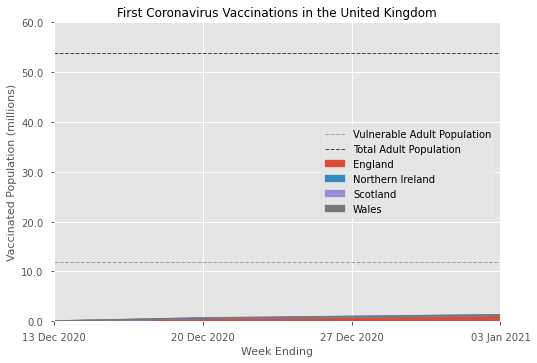

In [94]:
# Data
ax = shape_first.plot(xticks=shape_first.index, kind='area')
# Titles and Labels
ax.set_title('First Coronavirus Vaccinations in the United Kingdom')
ylab = ax.set_ylabel('Vaccinated Population (millions)')
xlab = ax.set_xlabel('Week Ending')

# Axis
ylim = ax.set_ylim(top=60000000)
yaxis = ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
xaxis = plt.xticks(shape.index, shape.index.strftime('%d %b %Y'))

# Lines
vulnline = ax.axhline(vulnerable, c='grey', ls='dashed', lw=1, alpha=0.7, label='Vulnerable Adult Population')
popline = ax.axhline(population, c='black', ls='dashed', lw=1, alpha=0.7, label='Total Adult Population')

# Style
plt.style.use('seaborn-notebook')

plt.legend()

plt.show()

### Second Vaccinations

In [98]:
shape_second = df[['date','areaName','cumPeopleReceivingSecondDose']].pivot(index='date', columns='areaName', values='cumPeopleReceivingSecondDose')
shape_second

areaName,England,Northern Ireland,Scotland,Wales
date,,,,
2020-12-13,NaN,0.0,0.0,0.0
2020-12-20,0.0,0.0,0.0,0.0
2020-12-27,0.0,0.0,0.0,0.0
2021-01-03,19981.0,1271.0,36.0,25.0


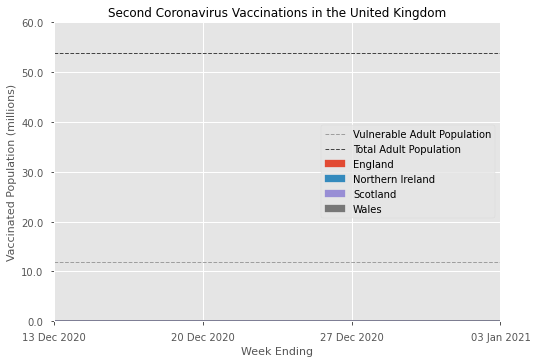

In [99]:
# Data
ax = shape_second.plot(xticks=shape_second.index, kind='area')
# Titles and Labels
ax.set_title('Second Coronavirus Vaccinations in the United Kingdom')
ylab = ax.set_ylabel('Vaccinated Population (millions)')
xlab = ax.set_xlabel('Week Ending')

# Axis
ylim = ax.set_ylim(top=60000000)
yaxis = ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
xaxis = plt.xticks(shape.index, shape.index.strftime('%d %b %Y'))

# Lines
vulnline = ax.axhline(vulnerable, c='grey', ls='dashed', lw=1, alpha=0.7, label='Vulnerable Adult Population')
popline = ax.axhline(population, c='black', ls='dashed', lw=1, alpha=0.7, label='Total Adult Population')

# Style
plt.style.use('seaborn-notebook')

plt.legend()

plt.show()

# Future work, monitoring progress
* On 10 January 2021, Matt Hancock tweeted that "the country" has vaccinated a third of the over 80s. Assumption: he's talking about England. [source](https://twitter.com/MattHancock/status/1348235558783512576)
* On 10 January 2021, Matt Hancock said that every adult could have a coronavirus vaccine by Autumn. Assumption: he's talking about all of the United Kingdom. [source](https://twitter.com/PippaCrerar/status/1348203365969362944)